# Wetterstation Kloten

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
from scipy import integrate
from scipy import optimize

## 1. Import der Daten
   - Beschreibt die Datenstruktur.
   - Zeigt auf, wie viele Messungen es sind.

In [29]:
#CSV-Datei laden
weather = np.loadtxt('Daten/Zürich21-22.csv', skiprows=1, delimiter=';', dtype=str)

#Daten nach KLO filtern
klo_weather = weather[weather[:, 0] == 'KLO']

In [30]:
#Daten transponieren
klo_weather_t = np.transpose(klo_weather)

#Arrays für die Daten bereitstellen
time        = klo_weather_t[1].astype("datetime64[m]").astype(float) #Zeit im Minutenintervall als float dargestellt
pressure    = klo_weather_t[2].astype(float)
temp        = klo_weather_t[3].astype(float)
rain        = klo_weather_t[4].astype(float)
sunshine    = klo_weather_t[5].astype(float)
time_diff   = klo_weather_t[6].astype(float)

### Beschreibung der Daten
- #stn: Wetterstation
- time: Zeitpunkt der Messung
- prestah0: Luftdruck [hPa]
- tre200h0: Lufttemperatur [°C]
- rre150h0: Niederschlagssumme [mm]
- su2000h0: Sonnenscheindauer [%]
- time_diff: Stunden seit Messbeginn [h]

### Anzahl Messungen

In [31]:
print("Anzahl Messungen:", len(klo_weather))

Anzahl Messungen: 7473


## 2. Da einige Datenpunkte fehlen, müsst ihr diese interpolieren.
   - Wählt dazu eine geeignete Methode und begründet eure Wahl.
   - Führt die Methode durch, um eine interpolierte Version der Daten mit mindestens doppelt so vielen Punkten zu erzeugen.

### Daten Interpolieren

In [32]:
# Maximaler Zeitunterschied bestimmen
max = int(np.max(time_diff))

#Erzeugen des Zeitvektors mit den fehlenden Stunden und Intervall auf Halbstundenbasis verkürzen
time_new = np.linspace(time.min(), time.max(), ((2*max)+1), dtype=int) 

#Daten kubische und linear interpolieren
f_cubic     = interp1d(time, klo_weather_t[2:6], kind='cubic')
f_linear    = interp1d(time, klo_weather_t[2:6], kind = 'linear')

#Die interpolierten Werte für Druck, Temperatur, Niederschlag und Sonnenschein werden in separaten Variablen für jede Interpolationsmethode gespeichert.
pressure_inter_cubic, temp_inter_cubic, rain_inter_cubic, sunshine_inter_cubic       = f_cubic(time_new)
pressure_inter_linear, temp_inter_linear, rain_inter_linear, sunshine_inter_linear   = f_linear(time_new)

#time zu datetime umwandeln für spätere Darstellungszwecke
time_datetime = time.astype("datetime64[m]")
time_datetime_inter = time_new.astype("datetime64[m]")

### Interpolationsmethode vergleichen

In [33]:
#Daten für Demo vorbereiten, damit der Bereich des Plots der Interpolationsdaten schneller geändert werden kann
datetime_demo= time_datetime[:25]
max_demo = 2 * int(np.max(time_diff[:25])) + 1

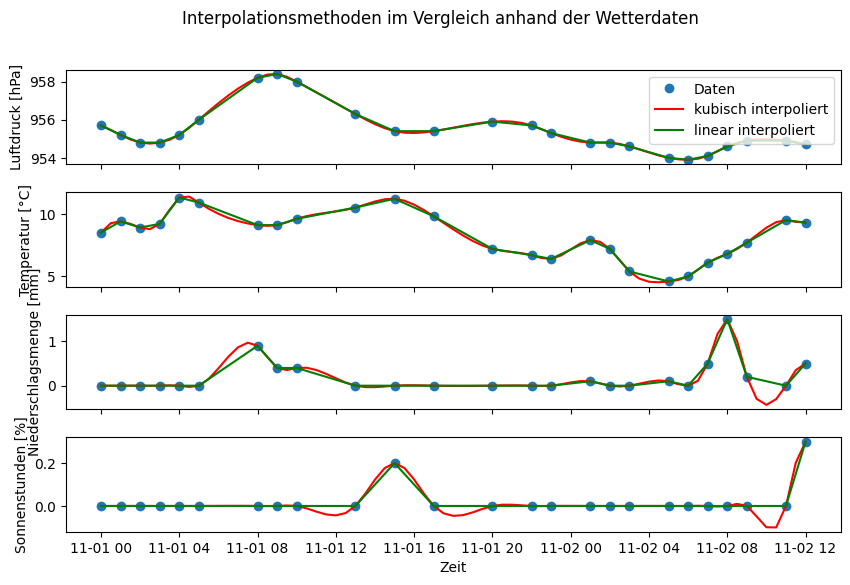

In [55]:
#Plot über einen bestimmten Zeitraum um die Interpolationsmethoden zu vergleichen
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,6))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.plot(datetime_demo, pressure[:25], 'o', label='Daten')
ax1.plot(time_datetime_inter[0:max_demo], pressure_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax1.plot(time_datetime_inter[0:max_demo], pressure_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax1.set_ylabel('Luftdruck [hPa]')
ax1.legend()

ax2.plot(datetime_demo, temp[:25], 'o', label='Daten')
ax2.plot(time_datetime_inter[0:max_demo], temp_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax2.plot(time_datetime_inter[0:max_demo], temp_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax2.set_ylabel('Temperatur [°C]')

ax3.plot(datetime_demo, rain[:25], 'o', label='Daten')
ax3.plot(time_datetime_inter[0:max_demo], rain_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax3.plot(time_datetime_inter[0:max_demo], rain_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax3.set_ylabel('Niederschlagsmenge [mm]')

ax4.plot(datetime_demo, sunshine[:25], 'o', label='Daten')
ax4.plot(time_datetime_inter[0:max_demo], sunshine_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax4.plot(time_datetime_inter[0:max_demo], sunshine_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax4.set_ylabel('Sonnenstunden [%]')

plt.xlabel('Zeit')
plt.suptitle('Interpolationsmethoden im Vergleich anhand der Wetterdaten')
plt.show()

### Auswahl der Interpolationsmethoden

Entscheidung: 
Da die kubische Interpolationsmethode eine präzisere Darstellung liefert und komplexere Schwankungen in den Daten darstellen kann, wurde diese Methode für die Temperatur- und die Luftdruckdaten verwendet. Die lineare Interpolation wäre ungenauer gewesen.

Die Sonnenstunden und die Niederschlagsmengen wurden linear interpoliert, da die lineare Interpolationsmethode eine angemessener Annäherung an die Daten bietet, insbesondere da die Werte nicht unter Null fallen können. 

## 3. Ihr sollt alle Variablen (Luftdruck, Temperatur, Regenmenge und Sonnenstunden) über einen selbstgewählten Zeitraum darstellen. 
   - Basisvariante: Wähle einen interessanten Zeitraum von 1-2 Wochen.
   - Schwierigere Variante (mehr Punkte): Errechne tageweise Durchschnitte, um die Variablen in einem grösseren Zeitraum (mehrere Monate/Quartal) darzustellen.

### Tagesdurschnitt berechnen

In [35]:
#Initalisieren der Variablen, um den Tagesdurschnitt zu berechnen
daily_pressure = np.array([]).astype(float)
daily_average_pressure = 0

daily_temp = np.array([]).astype(float)
daily_average_temp = 0

daily_rain = np.array([]).astype(float)
daily_average_rain = 0

daily_sunshine = np.array([]).astype(float)
daily_average_sun = 0

date = np.array([]).astype(datetime.date)

#für den letzten Tag wird der Durchschnitt nicht gerechnet, da die letzte stunde fehlt und somit wir die Daten für genau ein Jahr haben.
incomplete_hours = len(time_new) % 48

#Tagesdurschnitt berechnen (pro Tag 48 Messwerte)
for i in range(len(time_new) - incomplete_hours):
    daily_average_pressure += pressure_inter_cubic[i]
    daily_average_temp += temp_inter_cubic[i]
    daily_average_rain += rain_inter_linear[i]
    daily_average_sun += sunshine_inter_linear[i]
    if (i+1) % 48 == 0:
        daily_pressure = np.append(daily_pressure, daily_average_pressure/48)
        daily_average_pressure = 0
        daily_temp = np.append(daily_temp, daily_average_temp/48)
        daily_average_temp = 0
        daily_rain = np.append(daily_rain, daily_average_rain/48)
        daily_average_rain = 0
        daily_sunshine = np.append(daily_sunshine, daily_average_sun/48)
        daily_average_sun = 0
        date = np.append(date, time_datetime_inter[i].astype(datetime.datetime).date())



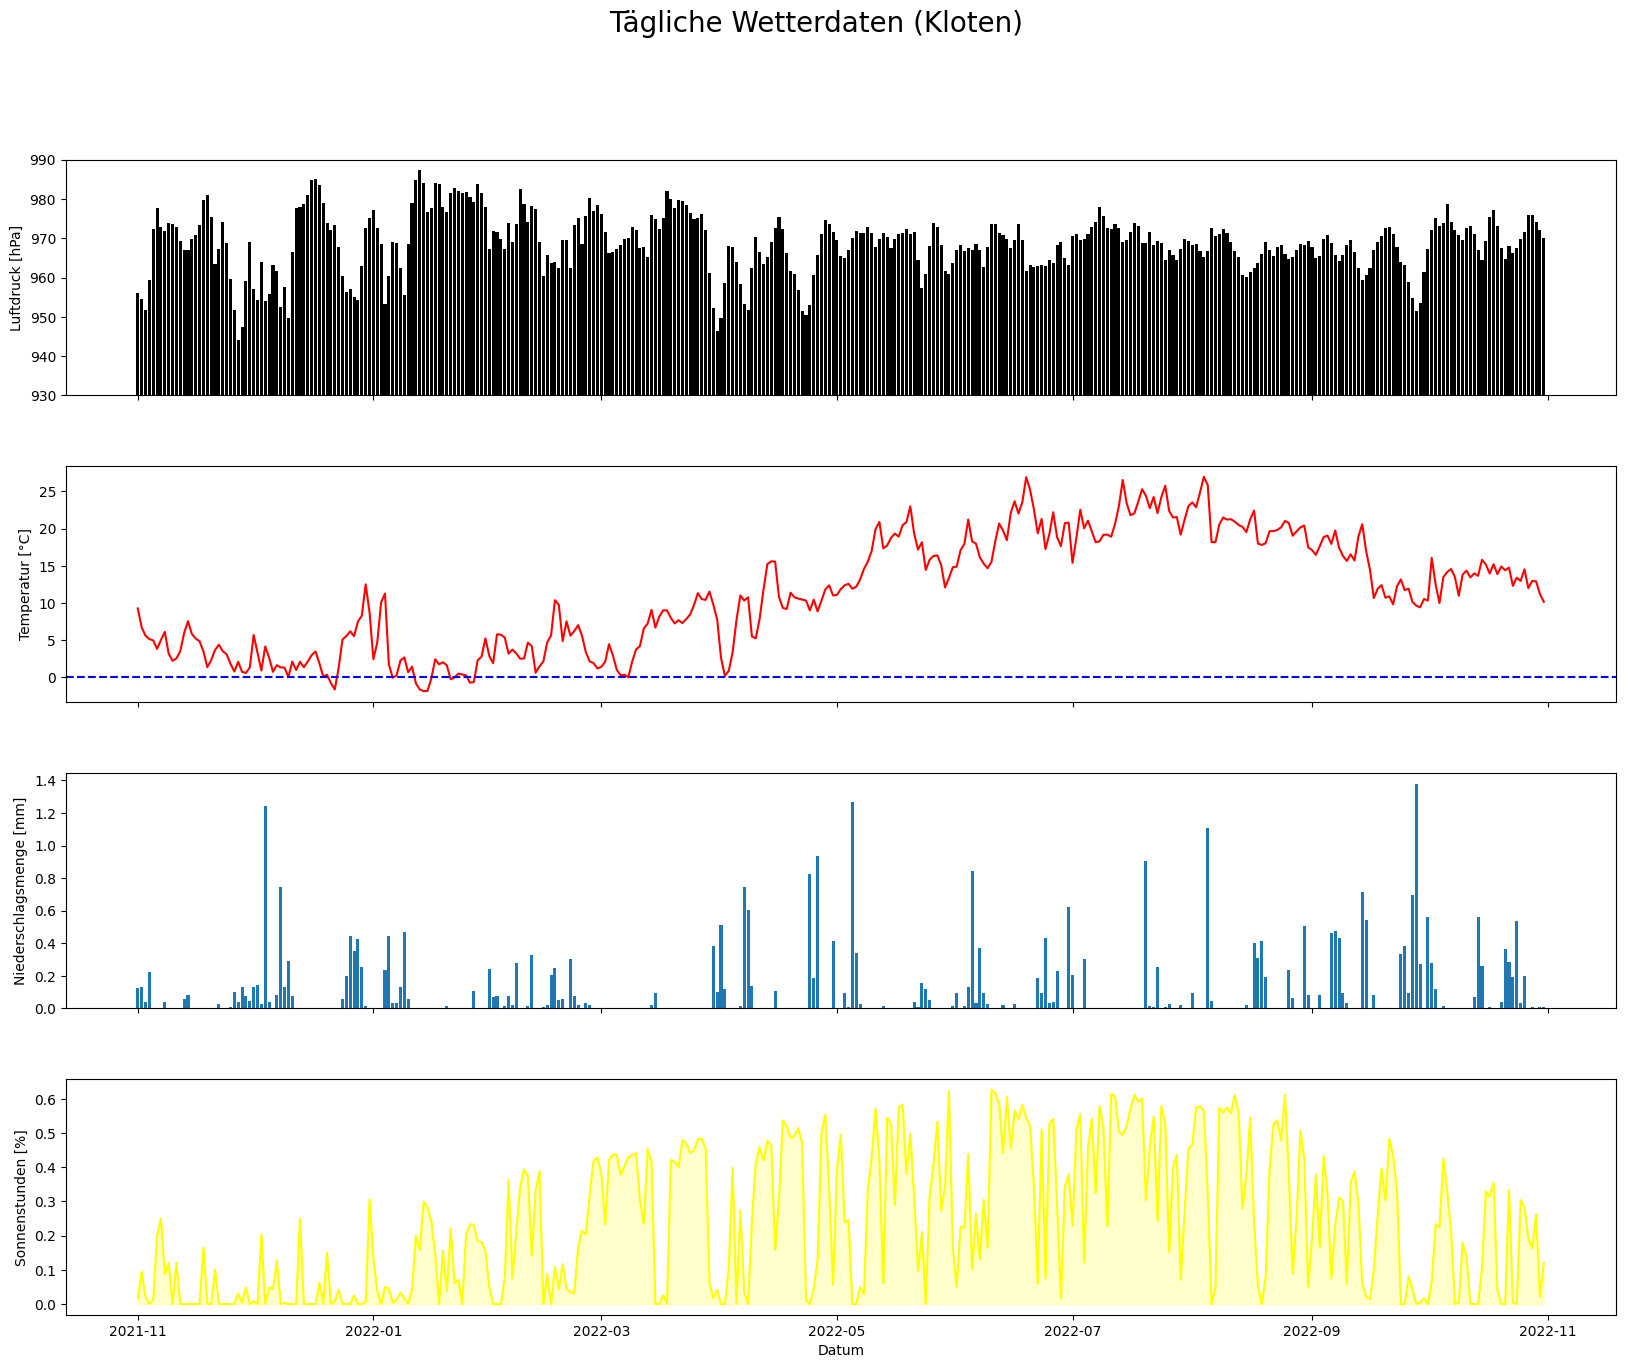

In [36]:
#Plot erstellen für die Tagesdurschnittsdaten
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,15))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.bar(date, daily_pressure, color='black')
ax1.set_ylim(930,990)
ax1.set_ylabel('Luftdruck [hPa]')


ax2.plot(date, daily_temp, color='red')
ax2.set_ylabel('Temperatur [°C]')
ax2.axhline(0, color='blue', linestyle='--')

ax3.bar(date, daily_rain)
ax3.set_ylabel('Niederschlagsmenge [mm]')

ax4.plot(date, daily_sunshine, color='yellow')
ax4.fill_between(date, daily_sunshine, 0, alpha=0.2, color='yellow')
ax4.set_ylabel('Sonnenstunden [%]')

plt.xlabel('Datum')
plt.suptitle('Tägliche Wetterdaten (Kloten)', fontsize=20)
plt.show()

## 4. Für die folgenden Punkte sollt ihr eine der Variablen auswählen.
   - Entweder Luftdruck, Temperatur, Regenmenge oder Sonnenstunden

#### Temperature it is!

In [37]:
#Nochmals interpolieren, damit wir eine Funktion haben mit nur den Temperatur daten
f_cubic_temp = interp1d(time, temp, kind='cubic')

## 5. Vergleicht die ursprünglichen Daten mit den interpolierten Daten und zeigt eure Erkenntnisse auf. 
   - Hier könnt ihr euch z.B. fragen, wie sich unterschiedliche Interpolationsmethoden verhalten.

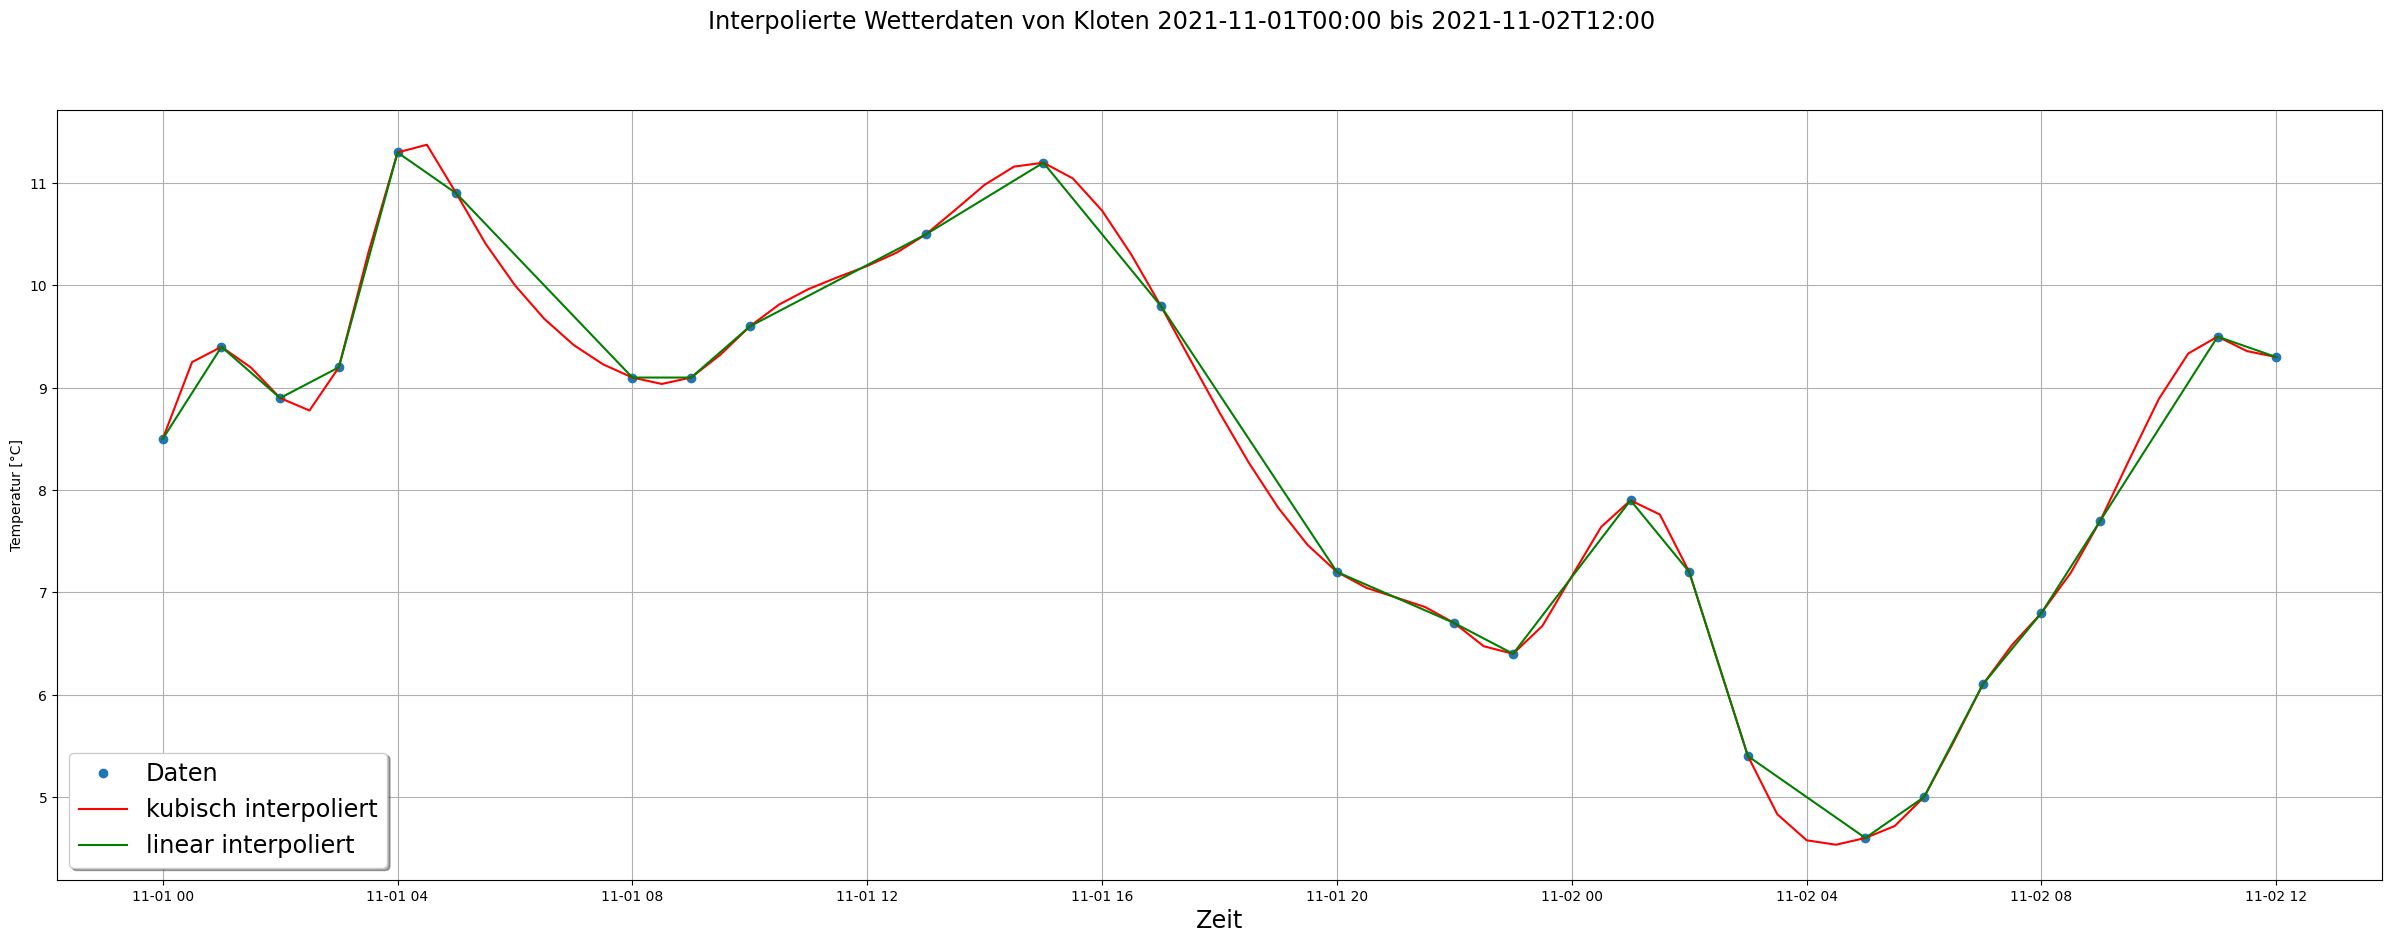

In [38]:
#Plot der unterschiedlich interpolierten Temperaturdaten erstellen
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(datetime_demo, temp[:25], 'o', label='Daten')
ax.plot(time_datetime_inter[0:max_demo], temp_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax.plot(time_datetime_inter[0:max_demo], temp_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax.set_ylabel('Temperatur [°C]')
ax.legend( loc='lower left', shadow=True, fontsize='xx-large')

plt.grid()
plt.xlabel('Zeit', fontsize='xx-large')

plt.suptitle('Interpolierte Wetterdaten von Kloten {0} bis {1}'.format(time_datetime_inter[0], time_datetime_inter[max_demo-1]), fontsize='xx-large')
plt.show()

kubische interpolation zu eckig... es wären mehr datenpunkte nötig um diese abzurunden.

## 6. Berechnet Nullstellen bzw. Schnittpunkte mit einem Schwellenwert und überlegt euch, welche Aussagen ihr daraus ableiten könnt.
Wir ermitteln zuerst an wie vielen Tagen die Temperatur in Kloten unter Null Grad fällt und danach versuchen wir mit numerischen Mitteln Zeitpunkte im Januar zu bestimmen in welchen genau Null Grad ist.

### Minustemperaturen auslesen & ausgeben

In [39]:
#hier kommt ein kommentar
nullstellen = np.where(temp_inter_linear < 0)

In [40]:
zer0temp_days = time_datetime_inter[nullstellen]

# Eindeutige Tage extrahieren
unique_days = np.unique(np.datetime_as_string(zer0temp_days, unit='D'))

In [41]:
print('Anzahltage mit Minustemperaturen:', len(unique_days))
print('Letzter Tag im Winter/Frühling 21/22 in dem die Temperatur nochmals unter Null fiel:' , unique_days[-1])

Anzahltage mit Minustemperaturen: 86
Letzter Tag im Winter/Frühling 21/22 in dem die Temperatur nochmals unter Null fiel: 2022-04-11


### Temperatur nahe 0 °C finden mit numerischen Mittel

1. Im ersten Teil des Codes werden die Start- und Endzeitpunkte für den betrachteten Zeitraum festgelegt. In diesem Fall wird der Zeitraum vom 1. Januar 2022 bis zum 14. Januar 2022 gewählt, da viele Nullstellen erwartet werden.
2. Um mögliche Nullstellen mit dem Auge zu erkennen wird anschließend wird ein Plot erstellt, der die Temperaturwerte im definierten Zeitraum zeigt.
3. Nachdem der Plot erstellt wurde, sollen die Nullstellen der Funktion f_cubic_temp im betrachteten Zeitraum ermittelt werden. Hierzu werden das Newtonverfahren und das Bisektionsverfahren verwendet. Das Newtonverfahren wird durch die Funktion optimize.newton aufgerufen und erhält als Startwert den Zeitpunkt des 1. Januar 2022. Das Bisektionsverfahren wird durch die Funktion optimize.bisect zweimal aufgerufen und erhält als Intervallgrenzen verschiedene Zeitpunkte im Januar 2022.
4. Die gefundenen Nullstellen werden in den Datentyp datetime64[m] konvertiert, um sie in dem Plot verwenden zu können. Dies erfolgt für alle drei Nullstellen zero1_datetime, zero4_datetime und zero5_datetime.
5. Im letzten Teil des Codes wird ein neuer Plot erstellt, der die Temperaturwerte im betrachteten Zeitraum sowie die gefundenen Nullstellen zeigt.

In [42]:
#Zeitraum mit vielen Nullstellen
january_start = np.datetime64('2022-01-01T00:00').astype(float)
january_start_index = int(np.where(time_new == january_start)[0])

january_end = np.datetime64('2022-01-14T23:30').astype(float)
january_end_index = int(np.where(time_new == january_end)[0])

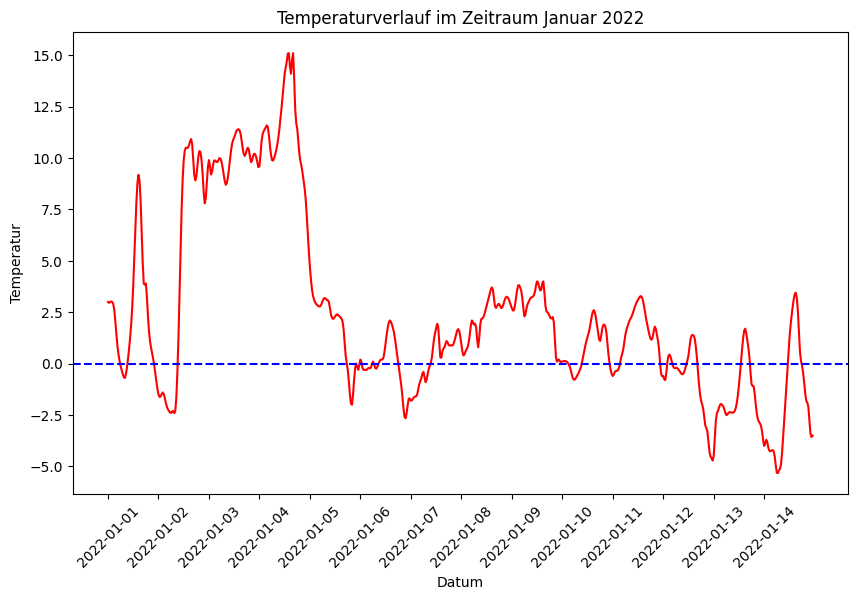

In [43]:
# Plot der Funktion
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_datetime_inter[january_start_index:january_end_index], temp_inter_cubic[january_start_index:january_end_index], color='red')
ax.axhline(0, color='blue', linestyle='--')

ax.set_xlabel('Datum')
x_ticks = np.arange(time_datetime_inter[january_start_index], time_datetime_inter[january_end_index], np.timedelta64(24, 'h'))
ax.set_xticks(x_ticks)

plt.xticks(rotation = 45)
plt.ylabel('Temperatur')
plt.title('Temperaturverlauf im Zeitraum Januar 2022')

plt.show()

In [44]:
#Nullstellen ermitteln mit dem Newtonverfahren
zero1 = optimize.newton(f_cubic_temp, np.datetime64('2022-01-01T00:00').astype(float)) 

#Nullstellen ermitteln mit dem Bisektionsverfahren
zero4 = optimize.bisect(f_cubic_temp, np.datetime64('2022-01-02T00:00').astype(float), np.datetime64('2022-01-03T00:00').astype(float))
zero5 = optimize.bisect(f_cubic_temp, np.datetime64('2022-01-01T12:00').astype(float), np.datetime64('2022-01-02T00:00').astype(float))

In [45]:
#Nullstellen wieder der x-Achse für den plot anpassen
zero1_datetime = zero1.astype("datetime64[m]")
zero4_datetime = np.float64(zero4).astype("datetime64[m]") #bisektion verfahren gibt den typ float zurück (und nicht typ np.float64) und dieser lässt sich nicht direkt in dateteim64 umwandeln
zero5_datetime = np.float64(zero5).astype("datetime64[m]")

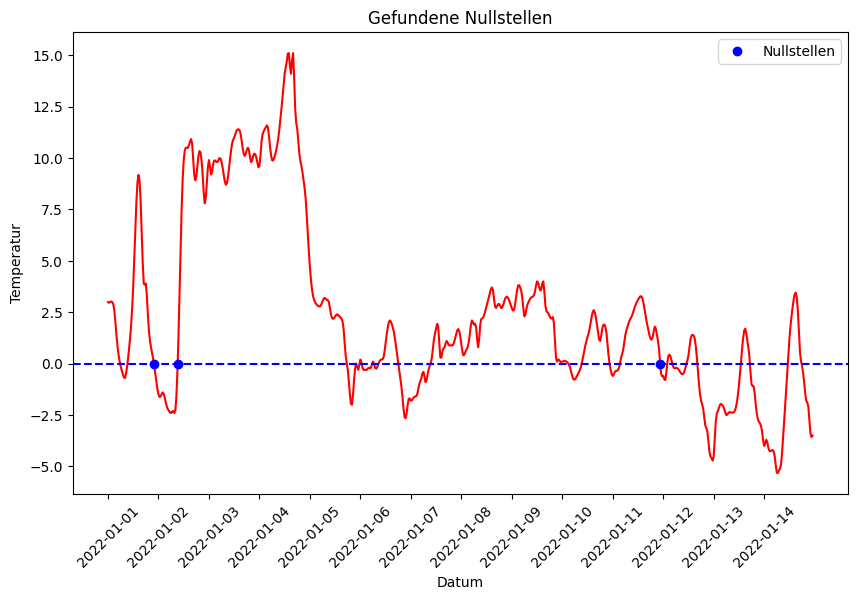

In [56]:
#Gefundene Nullstellen ploten
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_datetime_inter[january_start_index:january_end_index], temp_inter_cubic[january_start_index:january_end_index], color='red')

ax.plot([zero1_datetime, zero4_datetime, zero5_datetime], [f_cubic_temp(zero1),0,0], "ob", label="Nullstellen")
ax.axhline(0, color='blue', linestyle='--')

ax.set_xlabel('Datum')
ax.set_ylabel('Temperatur')
ax.set_title('Gefundene Nullstellen')

# Einen Tick pro Tag anzeigen
x_ticks = np.arange(time_datetime_inter[january_start_index], time_datetime_inter[january_end_index], np.timedelta64(24, 'h'))
ax.set_xticks(x_ticks)

plt.xticks(rotation=45)

ax.legend()
plt.show()

- Die Methoden sind recht genau sehr genau....
    - In der Newton-Methode hätte man noch einen toleranz Wert und Maximale wiederholeung angeben können um auf ein noch genaueres Ergebnis zu kommen. Das Ergebnis ist aber auch so genau genug für unsere Zwecke.
- Interpolation mit time hat das ganze Komplizierter gemacht mit hin und her formatieren des Zeitpunktes, ist aber für die Darstellung schöner.

erkentnisse probleme... -> f_cubic_temp bzw. interpolationsmethode den richtigen x-Wert benutzen 

Und wieso hat er bei Interpolation mit time_diff für temperatur nicht den gleichen wert zum beispiel für time_diff=1464.0 temp wäre = 3.0 bei der Interpolationsmethode 2.99999999

## 7. Mithilfe der Ableitung soll nach grossen Änderungen in den Daten gesucht werden. 
Hier wird der Tag mit der kleinsten und grösstenSteigung der Temperaturen ermittelt mit der np.gradient-Funktion.

1. Berechnung dier Steigung (bzw. den Gradienten) der Temperaturwerte in dem Array temp_inter_cubic.
2. Kleinster und grösster Wert auslesen uns ausgeben

In [47]:
#Steigung der Temperaturen berechnen
df = np.gradient(temp_inter_cubic)

#Index der kleinste steigung bzw. grösste Abnahme auslesen
i_min = np.argmin(df)
#Index der grössten steigung auslesen
i_max = np.argmax(df) 

print("maximale Abnahme:",(df[i_min]), "am", (time_datetime_inter[i_min])) 
print("maximale Zunahme:",(df[i_max]), "am", (time_datetime_inter[i_max]))

maximale Abnahme: -3.8999999999999986 am 2022-08-05T17:30
maximale Zunahme: 2.3 am 2022-02-24T09:30


Erkenntnis: np.gradient rechnet auch für den ersten und letzten wert eine Steigung -> für uns irrelevant?

Die Funktion np.gradient aus dem NumPy-Paket wird verwendet, um die numerische Ableitung der Temperaturwerte zu berechnen. Sie berechnet die Änderungsrate (Steigung) zwischen aufeinanderfolgenden Werten im Array und gibt ein neues Array zurück, das die berechneten Steigungswerte enthält.

Standardmäßig verwendet np.gradient eine Methode der zentralen Differenzen, bei der die Steigung am ersten Punkt und am letzten Punkt auf Basis der umliegenden Werte berechnet wird. Es wird eine symmetrische Differenz verwendet, die sowohl Werte vor dem betrachteten Punkt als auch Werte nach dem betrachteten Punkt einbezieht.

## 8. Benutze die Integration, um gewisse Durchschnittswerte über einen definierten Zeitraum zu berechnen.
In diesem Abschnitt werden die durchschnitts Temperatur über den Sommer aufzeigt mit hilfe der integrate.quad-Funktion aus dem scipy-Paket.

1. Zunächst werden die Start- und Enddaten des astronomischen Sommers auf der Nordhalbkugel definiert.

2. Die Funktion mean_func_extended wird definiert, um den Durchschnitt einer gegebenen Funktion über einen bestimmten Bereich zu berechnen. Die Funktion verwendet die integrate.quad-Funktion aus dem scipy-Paket, um das Integral der Funktion über mehrere Untereintervalle zu berechnen. Die Anzahl der Untereintervalle wird durch den Parameter num_subintervals festgelegt.

3. Die Funktion mean_func_extended wird verwendet, um den Durchschnitt der Temperatur über den Sommer zu berechnen. Der Funktionsname f_cubic_temp wird als Argument übergeben, zusammen mit den Start- und Enddaten des Sommers und der Anzahl der Untereintervalle (in diesem Fall 80).

4. Ein Diagramm wird erstellt, das die Temperatur während des Sommers darstellt. Die Funktion ax.plot wird verwendet, um die Temperaturdaten zwischen den Start- und Endindizes zu plotten. Eine horizontale Linie wird hinzugefügt, die den berechneten Durchschnitt der Temperatur darstellt. Das Diagramm enthält auch Achsentitel und eine Legende.

In [48]:
#Beginn des astronomischen Sommers auf der Nordhalbkugel 

#Beginn des astronomischen Sommers auf der Nordhalbkugel wird als Float-Wert abgespeichert, da unsere X-Achse unser interpolationsfunktion f_cubic_temp auch Zeitwerte als float hat.
summer_start = np.datetime64('2022-06-21T00:00').astype(float)
summer_start_index = int(np.where(time_new == summer_start)[0])

#Ende des astronomischen Sommers auf der Nordhalbkugel
summer_end = np.datetime64('2022-09-22T00:00').astype(float)
summer_end_index = int(np.where(time_new == summer_end)[0])

Funktion um die Funktion der interpolierten Daten zu integrieren. Dazu verwenden wir die scypi.integrate Funktion "quad". Für die Genauigkeit sind Subintervalle nötig, sonst gibt die Funktion "quad" eine Fehlermeldung aus. Nach dem Runden wäre das Ergebnis auch ohne Subintervalle korrekt, jedoch nehmen wir die wenige sekunden in kauf aufgrund ästhetischen Gründen (keine Fehlermeldung im Notebook).

Die Funktion mean_func_extended berechnet den durchschnittlichen Wert einer Funktion func über das Intervall von a bis b durch Aufteilung des Intervalls in num_subintervals Untereinheiten. Sie verwendet die Funktion integrate.quad aus dem Modul scipy.integrate, um das Integral der Funktion über jedes Untereinheit-Intervall zu berechnen.

In [49]:
#Durschnitt berechnen anhand eines Funktionsabschnitts unterteilt in intervalle
def mean_func_extended(func, a, b, num_subintervals):
    interval_width = (b - a) / num_subintervals
    integral_sum = 0.0

    for i in range(num_subintervals):
        subinterval_a = a + i * interval_width
        subinterval_b = subinterval_a + interval_width
        integral, error = integrate.quad(func, subinterval_a, subinterval_b)
        integral_sum += integral

    return integral_sum / (b - a)

In [50]:
#Durschnittstemperatur berechnung in den Sommertagen
mean_temp_extended = mean_func_extended(f_cubic_temp, summer_start, summer_end, 80) #80 Subintervalle, damit keine Fehlermeldung erscheint

#Durschnittstemperatur auf eine Nachkommastelle runden
mean_temp_rounded = round(mean_temp_extended, 1)

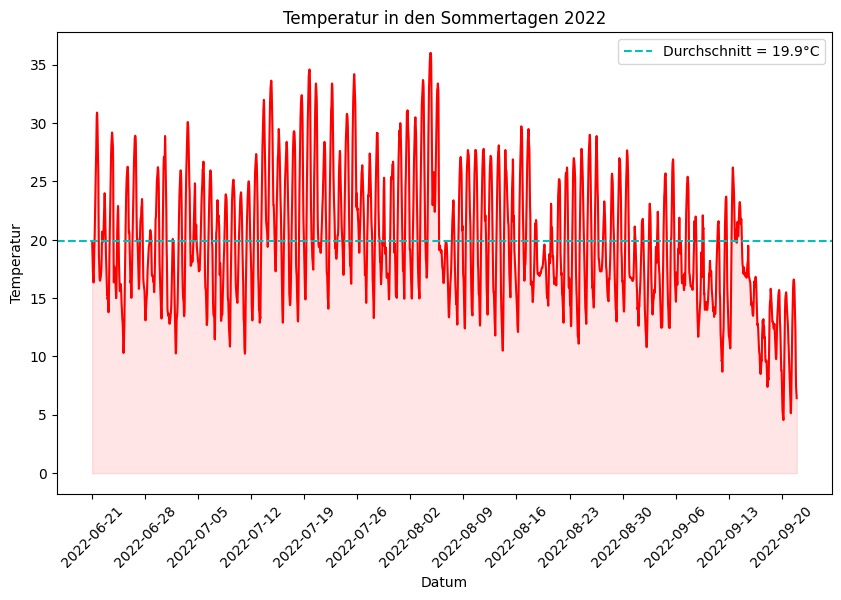

In [51]:
#Plot erstellen der Temperatur in den Sommertagen mit dem Durschnitt
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_datetime_inter[summer_start_index:summer_end_index], temp_inter_cubic[summer_start_index:summer_end_index], color='red')

ax.axhline(y=mean_temp_extended, color='c', linestyle='--', label='Durchschnitt = '+ str(mean_temp_rounded) + '°C')

ax.set_xlabel('Datum')
ax.set_ylabel('Temperatur')
ax.set_title('Temperatur in den Sommertagen 2022')

# Fill-Bereich zwischen den Kurven und der x-Achse
ax.fill_between(time_datetime_inter[summer_start_index:summer_end_index], temp_inter_cubic[summer_start_index:summer_end_index], 0, alpha=0.1, color='red')

# Einen Tick pro Tag anzeigen
x_ticks = np.arange(time_datetime_inter[summer_start_index], time_datetime_inter[summer_end_index], np.timedelta64(168, 'h'))
ax.set_xticks(x_ticks)

plt.xticks(rotation=45)

ax.legend()
plt.show()

In [52]:
print("Die Durschnittstemperatur durch den Sommer betrug", mean_temp_rounded, "°C")

Die Durschnittstemperatur durch den Sommer betrug 19.9 °C


#### Interpretation der Ergebnisse: 
Der Code berechnet den Durchschnitt der Temperatur während des Sommers auf der Nordhalbkugel. Die berechnete Durchschnittstemperatur wird auf eine Nachkommastelle gerundet und im Diagramm dargestellt. Der Plot zeigt die Temperatur während des Sommers und markiert den berechneten Durchschnitt als gestrichelte Linie. Durch das Füllen des Bereichs zwischen den Kurven und der x-Achse wird der Temperaturbereich visuell hervorgehoben. Das Diagramm liefert einen visuellen Überblick über die Temperaturänderungen während des Sommers.



## Zusammenfassung eurer wichtigsten Ergebnisse und Erkenntnisse
- Fügt am Ende des Notebooks eine Zusammenfassung eurer wichtigsten Ergebnisse und Erkenntnisse ein.
- Die Gruppenarbeit soll abschliessend hinsichtlich Zusammenarbeit, Rollenverteilung und Einschätzung der individuellen Beiträge reflektiert werden (am Ende des Jupyter Notebooks).

- schwierigkeiten mit Zeit und Datum
- gibt immer viele verschiedene Lösung, herausfinden welche passt am besten ist nicht einfach